# Deep Q-Learning Tutorial
In the last tutorial you saw how we implemented the Q-Learning algorithm on a simple environment - the Girdworld! In gridworld, the number of possible states in the environment is small (state space $=$ height $\times$ width), allowing the agent to visit all states when deriving the best Q-value function. In a given case like this, simple Q-learning works great and we can build an adequate RL model.

Consider now a continuous environment which has a possibly infinite state-space, like an Atari video game such as Pong or SuperMarioBros. Does Q-learning work the same? 

The answer is no. A fundamental flaw of the traditional Q-learning paradigm is its need to store the unique Q-function state-action pair for each state in a lookup-table. For an environment with infinite state-space, you would need to store infinite Q-function state-action pairs in an infinite table. This is not possible. To address this issue we can choose to model the Q-function as a deep learning models to provide us with state-action pairs.

We will have to make some adjustments to our algorithm first. The new Deep Q-Learning (DQN) algorithm is as follows:

### Deep Q-Learning (DQN) Algorithm

To accomodate our new continuous space setup, we introduce the replay buffer - where old memories of state-action pairs are sampled along with their rewards to train the model. We will model our Q-function as a feedforward neural network parameterized by parameters $\Theta$ which are randomly initialized and trained using backpropogation using the mean squared error (MSE) loss funciton.

1. We initialize the agent with the following
    - A replay buffer of a given size limit. Newest entries to the buffer will overide the oldest.
    - An action-value Q-function $Q$ with random parameters $\Theta$. 
    - A target action-value Q-function $\hat{Q}$ with parameters $\hat{\Theta} = \Theta$
2. Start the environment and allow the agent to interact with the environment and update/learn $\Theta$ at the same time. The goal is to learn an optimal set of parameters $\Theta$ during this interaction. 
    - During this interaction, the agent will fail many many times. So we decompose this interaction into a series of episodes where each episode is a session started from a default starting state and continues until the agent reaches a terminal state.
    - In our environment, this terminal state is either is one of two options 1) the agent drops the pole, or 2) the agent succesfully holds the pole for 1000 timesteps (around 20 seconds).
    - We train our model for a specified number of episodes or until sufficient successful terminal states has been achieved.
3. Outer loop: We loop through episodes until the stopping conditions above
    - Reset the environment and actor
    - Loop through episode one timestep at a time
        
    - Inner loop: Take a step in the environment and get a new state $S_t$
        - Actor decides on an action
            - With probablility $\varepsilon \in [0,1]$ make a random action. With probability $1-\varepsilon$ take an $a_t$ action given by $Q(S_t,\Theta)$.
        - Actor performs the action $a_t$ and observes the reward $R_t$ and next state $S_{t+1}$
        - Store $S_t$, $a_t$, $R_t$, and $S_{t+1}$ in the replay buffer.
        - Perform the replay step to train and update the target model $\hat{Q}$. This step is crucial to learning the model and is explained in more detail next.

#### The Replay Step
To train the agent we allow it to interact with the environment. At each timestep of the game the agent is given the vectorized state of the environment and then required to take an action. With a chance of epsilon, the agent takes a random action. With a chance of 1-epsilon, the feedforward neural network chooses the action.

To train this model, it is more efficient to replay past events, compare their success outcomes, and update the model parameters using backpropogation to converge to a stable solution.

At each timestep, we take a random sample of past non-consecutive events which are stored in a replay buffer (the self.memory queue). Each time the agent takes a step in the evironment the current state, chosen action, observed reward and next state are saved in the buffer. Given we have a batch size of 128 and a replay buffer of size 2000, we take a random sample of 128 [$S_t$, $a_t$, $R_t$, $S_{t+1}$] pairs. We then compute the Q-function of each and compare predicted q-values to target q-values with the Mean Squared Error loss function. This loss is propagated backwards through the network to learn a better model.

Remember, this is done for every step in the environment. As such, our model does not directly train on the exact last predicted action and state pair observed, but rather the last predicted state-action-reward pair is added to the queue replay buffer and we random sample 128 experienced steps from 2000 possible paris in this buffer to train.


# Cart-pole Environment
## Lets put this into code!
The following enviroment is a game where we try to balance a pole on top of a linear rail track. All we can decide is to either move the cart left or right. If the pole falls over, we lose! 

### Install dependencies on google colab notebook
These are installed on the notebook's server hosted at some google datacenter. Nothing is installed on your local machine.

In [1]:
#HIDE OUTPUT
!pip install swig
!pip install "gymnasium[other]"
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install opencv-python

### Setup the Deep Q-Learning agent

In [2]:
#Here we import some requried libraries
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import cv2
from IPython.display import Video
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("You are running this on", device)

###                                                   ###
#                                                       #
#                  DEFINING THE AGENT                   #
#                                                       #
# In this section we define the deep q-learning agent.  #
# We specify it's Q-function, modeled by a three layer. #
# feedforward neural network. By inputing the state of. #
# the environment into the Q-function, we get an predi- #
# ction of the best action to take at that timestep.    #
# We additionally specify a replay buffer which is used #
# to train the model.                                   #
###                                                   ###
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = 0.99  # discount factor
        self.epsilon = 1.0  # initial exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.9995
        self.batch_size = 128
        self.memory = deque(maxlen=2000)
        self.device = device
        self.m = nn.Softmax(dim=0)

        # Initialize Q-network and target network
        self.q_network = self.build_model().to(device)
        self.target_network = self.build_model().to(device)
        self.update_target_network()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.001) #We define the optimizer

    def build_model(self):
        # Our Q-function: a feedforward neural network model
        return nn.Sequential(
            nn.Linear(self.state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(),
            nn.Linear(128, self.action_dim)
        )

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def choose_action(self, state):
        if random.random() < self.epsilon:
            action = torch.rand(1).round()
            action = action.int().item()
            return action
        with torch.no_grad():            
            action = (self.q_network(torch.from_numpy(state).float().to(device))).cpu()
            action = torch.argmax(action)
            return action.item()

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        # The replay step explained earlier.
        #
        # At each timestep, we take a random sample of past non-consecutive events which are stored
        # in a replay buffer (the self.memory queue). Each time the agent takes a step in the evironment
        # the current state, chosen action, reward, and next observed state are saved in the buffer. 
        # Given we have a batch size of 128 and a replay buffer of size 2000, we take a random sample of
        # 128 [state, action, reward, state+1] pairs. We then compute the Q-function of each and compare 
        # predicted q-values to target q-values with the Mean Squared Error loss function. This loss is propagated backwards through
        # the network to learn a better model.
        #
        # Remember, this is done for every step in the environment. As such, our model does not directly 
        # train on the exact last predicted action and state pair observed, but rather the last predicted 
        # state-action-reward pair is added to the queue replay buffer and we random sample 128 experienced 
        # steps from 2000 possible paris in this buffer to train.

        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)

        states, actions, rewards, next_states, dones = zip(*batch)

        ## Storing arrays as torch tensors for efficiency
        states = torch.tensor(np.asarray(states), dtype=torch.float32, device=device)
        actions = torch.tensor(np.asarray(actions), dtype=torch.int64, device=device)
        rewards = torch.tensor(np.asarray(rewards), dtype=torch.float32, device=device)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
        dones = torch.tensor(dones, dtype=torch.bool, device=device)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1))
        next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(-1)
        target_q_values = rewards.unsqueeze(-1) + self.gamma * next_q_values * ~dones.unsqueeze(-1)

        loss = nn.MSELoss()(q_values, target_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon. Here we reduce the chance of random exploration (as opposed to
        # neural network Q-function exploration) with each timestep. At the start of the
        # training, we have a 99% chance of random action and 1% chance of model action
        # By the end of the training, we have a 1% chance of random action and 99% chance of
        # model action.
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


You are running this on cpu


In [4]:
###                                                   ###
#                                                       #
#                    TRAINING AGENT                     #
#                                                       #
###                                                   ###
def train_dqn(env, agent, episodes=1000, target_update=10):
    total_rewards = []
    max_num_steps = 1000
    done_learning = False
    max_reached = 0

    # We loop through episodes until we reach a max episode. Each episode is a complete game run in which the agent 
    # interacts with its environment. When the episode ends, the environment and agent is reset to the default state.
    for episode in range(episodes):
        if done_learning:
            break
        state, _ = env.reset()
        total_reward = 0
        step = 0

        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _, _ = env.step(action)

            agent.store_transition(state, action, reward, next_state, done)
            agent.replay()

            state = next_state
            total_reward += reward
            step += 1

            #If we reach the maximum score (we survived to the last step of the simulation)
            if step >= max_num_steps:
                max_reached += 1
                if max_reached >= 3: #lets reach the highest score three times before early stopping training
                    done_learning = True
            
                total_rewards.append(total_reward)
                break
                
            #If we terminated the game (due falling cart or moving off-screen)   
            if done:
                total_rewards.append(total_reward)
                break

        if episode % target_update == 0:
            agent.update_target_network()

        if episode % 10 == 0:
            print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {agent.epsilon}")

    return total_rewards


###                                                   ###
#                                                       #
#                    AGENT EVALUATION                   #
#                                                       #
###                                                   ###
def evaluate_agent(env, agent, episodes=5, record=False, video_folder='videos'):
    if record:
        env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: True)
    
    max_num_steps = 1000
    total_rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0

        step = 0
        done = False
        print("running episode", episode)
        while not done:
            action = agent.choose_action(state)

            next_state, reward, done, _, _ = env.step(action)
            state = next_state
            total_reward += reward
            step += 1

            done = False
            if step > max_num_steps:
                done = True
        total_rewards.append(total_reward)

    env.close()
    return total_rewards


### Lets initialize the environment and model

In [5]:
# Init the environment
env = gym.make('CartPole-v1',render_mode="rgb_array")
state_dim = np.prod(env.observation_space.shape)
action_dim = np.prod(env.action_space.n)
agent = DQNAgent(state_dim, action_dim)


### Now, lets run the untrained model to see how it performs

In [6]:
# Evaluate the untrained agent and record video
print("Evaluating untrained agent...")
evaluate_agent(env, agent, episodes=1, record=True, video_folder='videos/before_training')

# SOMETIMES THIS CRASHES... RUN AGAIN. IT IS AN OCCASIONAL ERROR WITH THE VIDEO RECORDING

Evaluating untrained agent...
running episode 0


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /teamspace/studios/this_studio/videos/before_training folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/gymnasium/envs/classic_control/cartpole.py:214: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


[20.0]

In [7]:
Video("videos/before_training/rl-video-episode-0.mp4")

### That was bad.. lets train 💪 

Training agent...
Episode 0, Reward: 19.0, Epsilon: 1.0


/tmp/ipykernel_2174137/3305305810.py:88: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  next_states = torch.tensor(next_states, dtype=torch.float32, device=device)


Episode 10, Reward: 13.0, Epsilon: 0.9431644419191232
Episode 20, Reward: 15.0, Epsilon: 0.8516836376843847
Episode 30, Reward: 36.0, Epsilon: 0.7117098046837247
Episode 40, Reward: 47.0, Epsilon: 0.5734187385492617
Episode 50, Reward: 58.0, Epsilon: 0.3845278908657794
Episode 60, Reward: 464.0, Epsilon: 0.09152914578219735


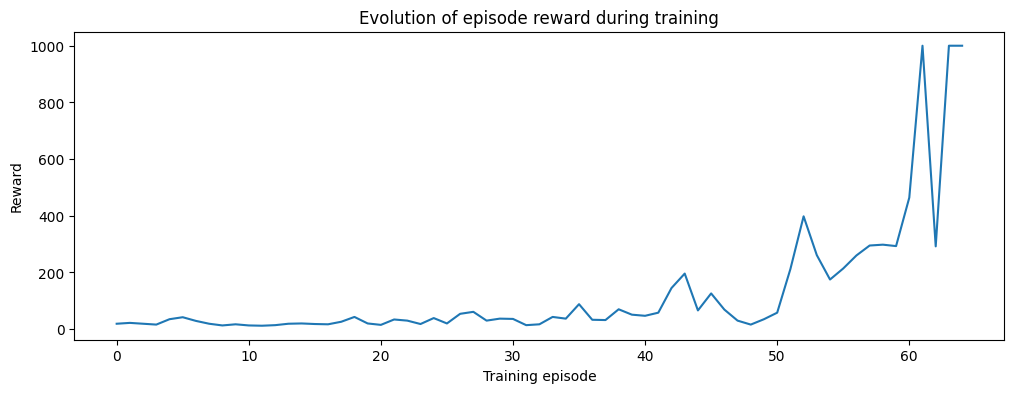

In [8]:
# Train the agent
print("Training agent...")
total_rewards = train_dqn(env, agent, episodes=500, target_update=1)
env.close()

# Plot results of training
plt.figure(figsize=(12,4), dpi= 100)
plt.plot(total_rewards)
plt.ylabel("Reward")
plt.xlabel("Training episode")
plt.title("Evolution of episode reward during training")
plt.show()

# If the model does not fully train within the given number of episodes, start again. If you reached the max number of 
# episodes, that means the model did not fully learn. 


A reward of +1 is given for each frame the agent has correctly balanced the pole. A perfect score of 1000 is awarded to the agent if it has balanced it for 1000 frames.

### Now lets look at the results after training!

In [9]:
# Evaluate the trained agent and record video
print("Evaluating trained agent...")
evaluate_agent(env, agent, episodes=1, record=True, video_folder='videos/after_training')

# SOMETIMES THIS CRASHES... RUN AGAIN. IT IS AN OCCASIONAL ERROR WITH THE VIDEO RECORDING


Evaluating trained agent...
running episode 0


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /teamspace/studios/this_studio/videos/after_training folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[1001.0]

In [10]:
Video("videos/after_training/rl-video-episode-0.mp4")

And if everything worked, we should have a balancing pole! 

If you had fun and would like more practice, feel free to adapt this notebook to another game. You can find more here https://gymnasium.farama.org/. A warning, some of these games take much longer to train and thus its recommended to try more advanced RL mehtods, such as Proximal Policy Optimization (PPO).  Enjoy :)